# VQE Example

In [1]:
# Where to find this code?
# https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
#from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
#service = QiskitRuntimeService(channel="ibm_quantum")
#backend = service.least_busy(operational=True, simulator=False)

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrEstimatorV2 as Estimator

provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits = 2)


In [3]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

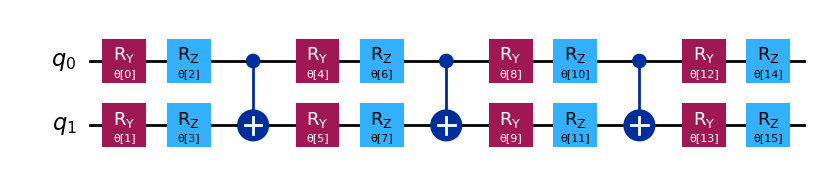

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [5]:
num_params = ansatz.num_parameters
num_params

16

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

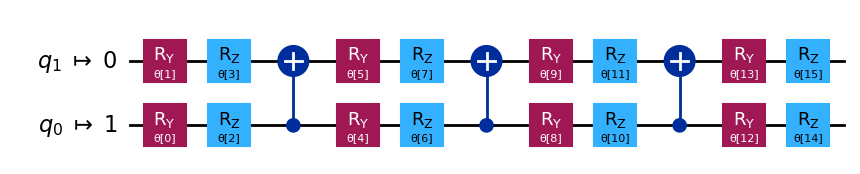

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [9]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    
  
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [10]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [11]:
x0 = 2 * np.pi * np.random.random(num_params)

In [12]:
x0

array([4.56540515, 1.75128513, 5.91131155, 1.7391921 , 2.59282932,
       2.7492441 , 5.15476581, 0.99109984, 3.39292909, 2.89356259,
       4.0750673 , 1.23683026, 4.18918897, 0.82554628, 4.96674947,
       0.39142382])

In [13]:
with Session(backend=backend) as session:
    #estimator = Estimator(mode=session)
    estimator = Estimator(backend=backend)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

C:\Users\vkasi\.conda\envs\QiskitNew\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Iters. done: 1 [Current cost: [0.015363085937500007]]
Iters. done: 2 [Current cost: [0.15521210937500002]]
Iters. done: 3 [Current cost: [0.037598632812500005]]
Iters. done: 4 [Current cost: [-0.16597773437500002]]
Iters. done: 5 [Current cost: [-0.5212265625]]
Iters. done: 6 [Current cost: [-0.7275572265625]]
Iters. done: 7 [Current cost: [-0.35972734375]]
Iters. done: 8 [Current cost: [-0.6028781250000002]]
Iters. done: 9 [Current cost: [-0.49941503906250007]]
Iters. done: 10 [Current cost: [-0.5935625]]
Iters. done: 11 [Current cost: [-0.3924388671875]]
Iters. done: 12 [Current cost: [-0.58218671875]]
Iters. done: 13 [Current cost: [-0.35479648437500005]]
Iters. done: 14 [Current cost: [-0.53388359375]]
Iters. done: 15 [Current cost: [-0.47557011718750003]]
Iters. done: 16 [Current cost: [-0.718384375]]
Iters. done: 17 [Current cost: [-0.599245703125]]
Iters. done: 18 [Current cost: [-0.7352267578125]]
Iters. done: 19 [Current cost: [-0.6604880859375002]]
Iters. done: 20 [Current co

In [15]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.8160978515624999
       x: [ 4.822e+00  1.912e+00 ...  1.352e+00  6.207e+00]
    nfev: 165
   maxcv: 0.0

In [16]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [17]:
cost_history_dict["iters"] == res.nfev

True

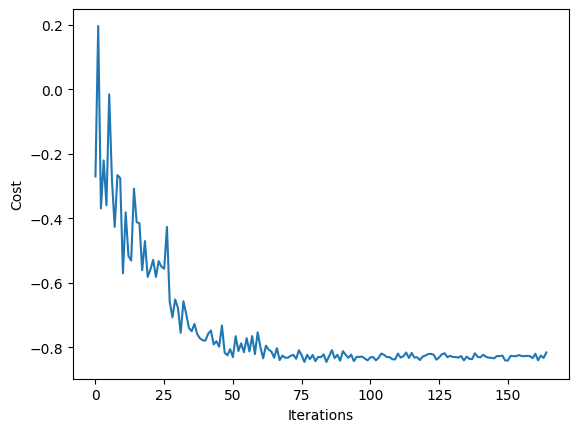

In [18]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()